# Predicting All-NBA Team and Player Salaries - Final Models and Testing
---

Up until now, we have tested several regression models, and a few classification ones as well, predicting All-NBA Team placement and salary. In this notebook, we will choose our final models and test them on our holdout data. 

In this notebook, we will build upon the regression and classification models we have tested previously to predict All-NBA Team placement and salary. After carefully evaluating various regression and classification models, we will now select and move forward with the best-performing ones to test on our holdout data. We will start by comparing the performance of each model, retraining each model using all the data from the training and validation sets, and testing on the holdout years. 

We will be copying over our final models to this notebook, as they are relatively straightforward. However, as the complexity increases, we will transition to using **pickling** to save and load our models efficiently.

By the end of this notebook, we aim to have a refined and reliable set of models that can effectively predict All-NBA Team placement and salary for future data.

Further detailed notebooks on the various segments of this project can be found at the following: 
- [01_Data_Acquisition](./01_Data_Acquisition.ipynb)
- [02_Data_Cleaning](./02_Data_Cleaning.ipynb)
- [03_Preliminary_EDA](./03_Preliminary_EDA.ipynb)
- [04_Data_Modeling_I](./04_Data_Modeling_I.ipynb)
- [05_Data_Modeling_II](./05_Data_Modeling_II.ipynb)

For more information on the background, a summary of methods, and findings, please see the associated [README](../README.md) for this analysis.

## Contents

---

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import shap
import streamlit as st


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVR, SVR, SVC
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import datetime

import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

---
## I. Model Summary

### Regression: Predicting All-NBA Team Top15 Players

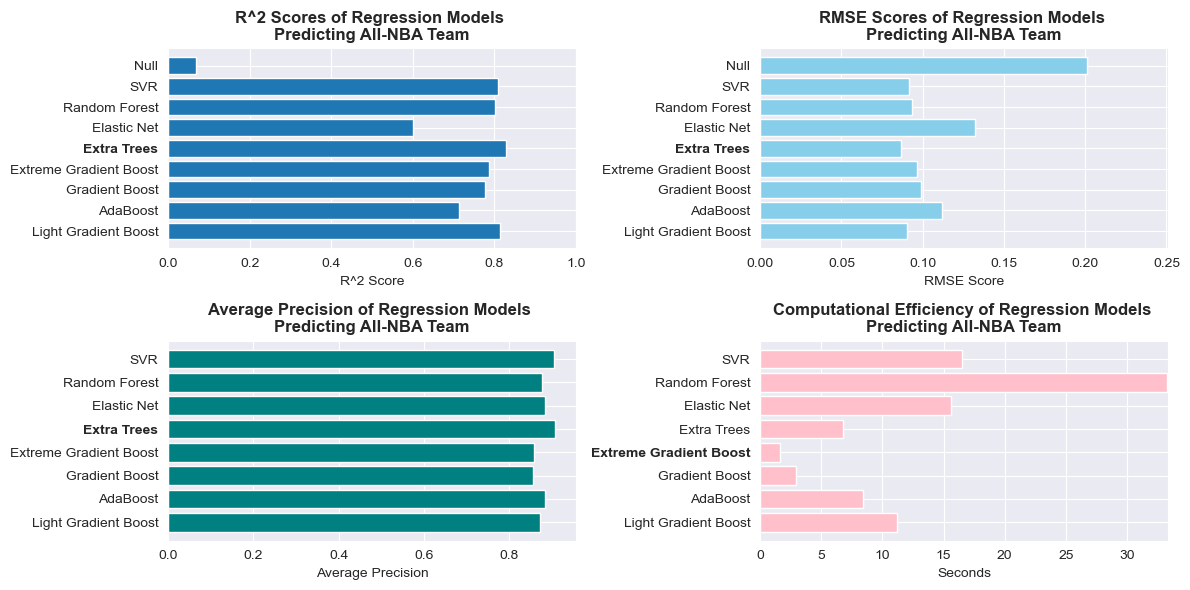

<Figure size 640x480 with 0 Axes>

In [2]:
sns.set_style('darkgrid')
models = ['Null', 'SVR', 'Random Forest', 'Elastic Net', 'Extra Trees', 'Extreme Gradient Boost', 'Gradient Boost', 'AdaBoost', 'Light Gradient Boost']
test_scores = [0.0681, 0.8085, 0.8011, 0.6014, 0.8279, 0.7863, 0.7764, 0.7133, 0.8131]
rmse_scores = [0.2009, 0.0914, 0.0931, 0.1319, 0.0866, 0.0966, 0.0988, 0.1118, 0.0903]

models2 = ['SVR', 'Random Forest', 'Elastic Net', 'Extra Trees', 'Extreme Gradient Boost', 'Gradient Boost', 'AdaBoost', 'Light Gradient Boost']
avg_ap = [0.90475, 0.8755, 0.8835, 0.90575, 0.8585, 0.85475, 0.8845, 0.87175]
times = [16.5, 33.3, 15.6, 6.75, 1.66, 2.92, 8.43, 11.2]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

#pref_order = ['Null', 'SVR', 'Random Forest', 'Elastic Net', 'Extra Trees', 'Extreme Gradient Boost', 'Gradient Boost', 'AdaBoost', 'Light Gradient Boost']
#colors = ['#1f77b4', 'lightcoral', 'teal', 'pink', 'skyblue','orange', 'mediumseagreen', 'tab:red', 'tab:cyan']

# Plot Test Scores
axs[0,0].barh(models, test_scores)
axs[0,0].set_xlim(0, 1.0)
axs[0,0].set_xlabel('R^2 Score')
axs[0,0].set_title('R^2 Scores of Regression Models \nPredicting All-NBA Team', fontweight='bold')
#axs[0,0].set_yticklabels(pref_order)
axs[0,0].invert_yaxis() 

# Plot RMSE Scores
axs[0,1].barh(models, rmse_scores, color='skyblue')
axs[0,1].set_xlim(0, max(rmse_scores) + 0.05)
axs[0,1].set_xlabel('RMSE Score')
axs[0,1].set_title('RMSE Scores of Regression Models \nPredicting All-NBA Team', fontweight='bold')
#axs[0,1].set_yticklabels(pref_order)
axs[0,1].invert_yaxis()  

# Plot Avg Precision
axs[1,0].barh(models2, avg_ap, color='teal')
axs[1,0].set_xlim(0, max(avg_ap) + 0.05)
axs[1,0].set_xlabel('Average Precision')
axs[1,0].set_title('Average Precision of Regression Models \nPredicting All-NBA Team', fontweight='bold')
#axs[1,0].set_yticklabels(pref_order)
axs[1,0].invert_yaxis()  

# Plot Time to Compute
axs[1,1].barh(models2, times, color='pink')
axs[1,1].set_xlim(0, max(times) + 0.05)
axs[1,1].set_xlabel('Seconds')
axs[1,1].set_title('Computational Efficiency of Regression Models \nPredicting All-NBA Team', fontweight='bold')
#axs[1,1].set_yticklabels(pref_order)
axs[1,1].invert_yaxis() 

#Source: https://stackoverflow.com/questions/56441603/how-to-change-the-font-weight-of-individual-colorbar-labels; ChatGPT
highest_index_r2 = np.argmax(test_scores)
highest_index_rmse = np.argmin(rmse_scores)
highest_index_ap = np.argmax(avg_ap)
highest_index_times = np.argmin(times)

axs[0,0].get_yticklabels()[highest_index_r2].set_fontweight('bold')
axs[0,1].get_yticklabels()[highest_index_rmse].set_fontweight('bold')
axs[1,0].get_yticklabels()[highest_index_ap].set_fontweight('bold')
axs[1,1].get_yticklabels()[highest_index_times].set_fontweight('bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show();

plt.savefig('../images/Reg1_Model_Performances.png', dpi=192, bbox_inches='tight'); #Added

##### <span style = 'color:mediumvioletred'> _<u>**Extra Trees**</u> had the highest R^2 (>80%) and Average Precision (~91%), lowest RMSE (<0.1), and good computational efficiency (<10 seconds to run). Therefore, we will choose it as our final model._

### Multiclass Classification: Predicting 1st, 2nd, or 3rd Team

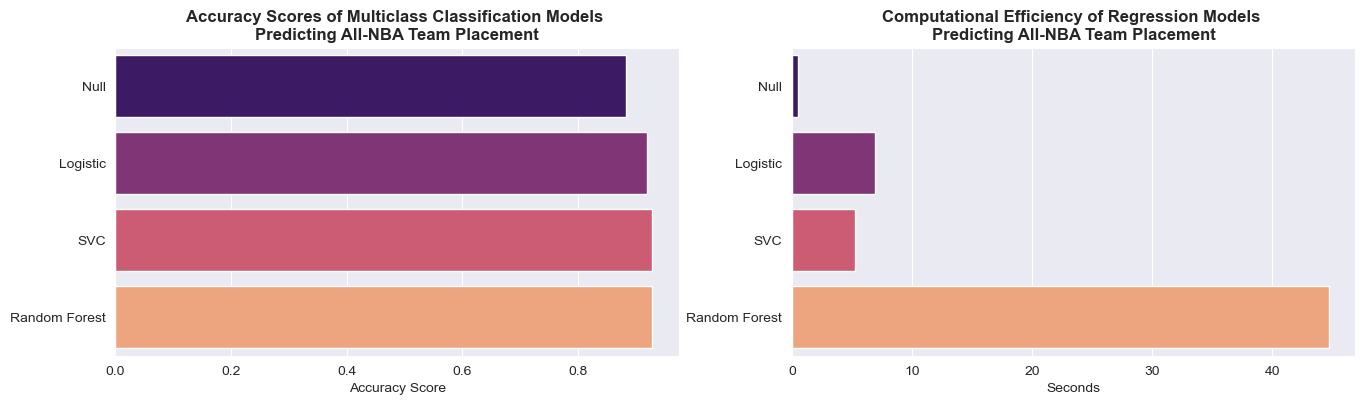

In [3]:
models = ['Null', 'Logistic', 'SVC', 'Random Forest']
accuracy_scores = [0.8842, 0.9192, 0.9288, 0.9288]
times = [0.5, 6.9, 5.27, 44.7]
overall = pd.DataFrame({'Model': models, 'Accuracy_Score': accuracy_scores, 'Times': times})

fig, ax = plt.subplots(1,2, figsize=(16,4))
#overall.sort_values(by = 'Accuracy_Score', ascending=False, inplace=True)
sns.barplot(y=overall['Model'], x=overall['Accuracy_Score'], order=overall['Model'], palette='magma', ax=ax[0])
ax[0].set_title('Accuracy Scores of Multiclass Classification Models \nPredicting All-NBA Team Placement', fontweight='bold')
ax[0].set_xlabel('Accuracy Score')
ax[0].set_ylabel(None)

#overall.sort_values(by = 'Times', inplace=True)
sns.barplot(y=overall['Model'], x=overall['Times'], order=overall['Model'], palette='magma', ax=ax[1])
ax[1].set_title('Computational Efficiency of Regression Models \nPredicting All-NBA Team Placement', fontweight='bold')
ax[1].set_xlabel('Seconds')
ax[1].set_ylabel(None);

plt.savefig('../images/Multi_Model_Performances.png', dpi=192, bbox_inches='tight');

##### <span style = 'color:mediumvioletred'> _For placing NBA players into 1st, 2nd, or 3rd team categories, <u>**SVC**</u> is the model we will select. While this task appeared to be difficult, as there exists much nuance and noise around determining these granular team placements, SVC performed better than the null model (~93% vs. ~88%) and logistic regression, and performed the same as Random Forest, but had the best computational efficiency._

### Binary Classification: Predicting All-NBA Team Selection or No Selection

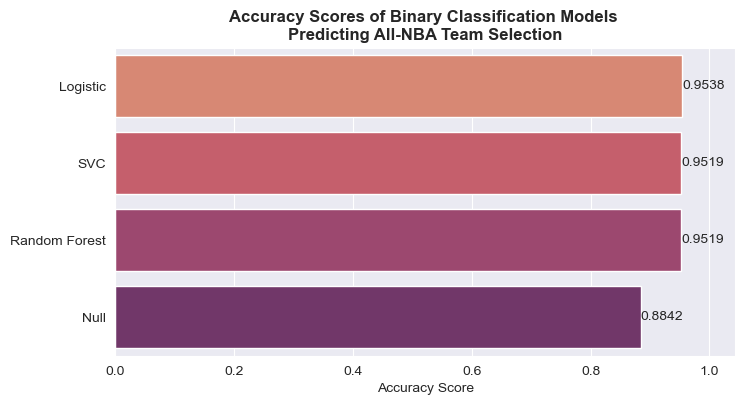

In [4]:
models = ['Null', 'Logistic', 'SVC', 'Random Forest']
accuracy_scores = [0.8842, 0.9538, 0.9519, 0.9519]
overall = pd.DataFrame({'Model': models, 'Accuracy_Score': accuracy_scores})

plt.figure(figsize=(8,4))
overall.sort_values(by = 'Accuracy_Score', ascending=False, inplace=True)
sns.barplot(y=overall['Model'], x=overall['Accuracy_Score'], order=overall['Model'], palette='flare')
plt.title('Accuracy Scores of Binary Classification Models \nPredicting All-NBA Team Selection', fontweight='bold')
plt.xlabel('Accuracy Score')
plt.ylabel(None)

# Add bar values
# source: https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars, ChatGPT
for i, score in enumerate(overall['Accuracy_Score']):
    plt.text(score, i, f"{score:.4f}", va='center', ha='left')
plt.xlim(0, max(overall['Accuracy_Score']) + .09);

plt.savefig('../images/Binary_Model_Performances.png', dpi=192, bbox_inches='tight'); #Added

##### <span style = 'color:mediumvioletred'> _For placing NBA players into binary categories of either being selected for an All-NBA Team or not, <u>**Logistic Regression**</u> is the best model. It had the highest accuracy (95.4% compared to null models 88.42%) and good computation efficiency, as seen in the multiclass classification as well._

### Regression: Predicting NBA Salaries for Player Valuation

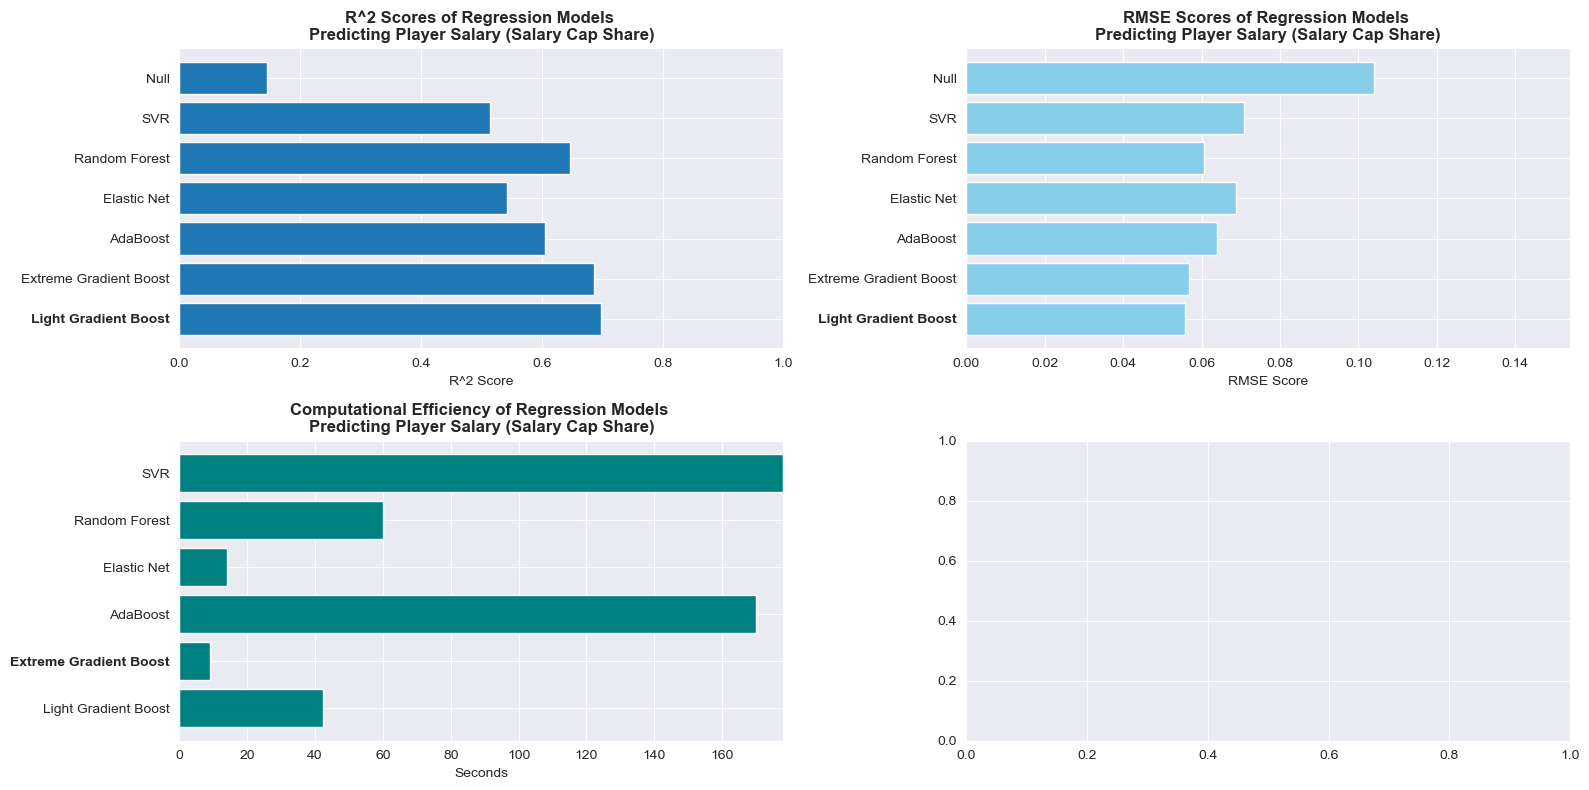

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set_style('darkgrid')
models = ['Null', 'SVR', 'Random Forest', 'Elastic Net', 'AdaBoost', 'Extreme Gradient Boost', 'Light Gradient Boost']
test_scores = [0.1455, 0.5135, 0.6461, 0.5426, 0.6046, 0.6871, 0.6978]
rmse_scores = [0.104, 0.0709, 0.0605, 0.0688, 0.0639, 0.0569, 0.0559]

models2 = ['SVR', 'Random Forest', 'Elastic Net', 'AdaBoost', 'Extreme Gradient Boost', 'Light Gradient Boost']
times = [178, 60, 14, 170,	9.14, 42.4]

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot Test Scores
axs[0,0].barh(models, test_scores)
axs[0,0].set_xlim(0, 1.0)
axs[0,0].set_xlabel('R^2 Score')
axs[0,0].set_title('R^2 Scores of Regression Models \nPredicting Player Salary (Salary Cap Share)', fontweight='bold')
axs[0,0].invert_yaxis() 

# Plot RMSE Scores
axs[0,1].barh(models, rmse_scores, color='skyblue')
axs[0,1].set_xlim(0, max(rmse_scores) + 0.05)
axs[0,1].set_xlabel('RMSE Score')
axs[0,1].set_title('RMSE Scores of Regression Models \nPredicting Player Salary (Salary Cap Share)', fontweight='bold')
axs[0,1].invert_yaxis()  

# Plot Time to Compute
axs[1,0].barh(models2, times, color='teal')
axs[1,0].set_xlim(0, max(times) + 0.05)
axs[1,0].set_xlabel('Seconds')
axs[1,0].set_title('Computational Efficiency of Regression Models \nPredicting Player Salary (Salary Cap Share)', fontweight='bold')
axs[1,0].invert_yaxis() 

#Source: https://stackoverflow.com/questions/56441603/how-to-change-the-font-weight-of-individual-colorbar-labels; ChatGPT
highest_index_r2 = np.argmax(test_scores)
highest_index_rmse = np.argmin(rmse_scores)
highest_index_times = np.argmin(times)

axs[0,0].get_yticklabels()[highest_index_r2].set_fontweight('bold')
axs[0,1].get_yticklabels()[highest_index_rmse].set_fontweight('bold')
axs[1,0].get_yticklabels()[highest_index_times].set_fontweight('bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show();

plt.savefig('../images/Reg2_Model_Performances.png', dpi=192, bbox_inches='tight'); 

##### <span style = 'color:mediumvioletred'> _For predicting NBA player salary using salary cap share as our target, the Light Gradient Boost Machine (LGBM) was the most powerful model. Many models did not perform well for this task, but LGBM was about to discover patterns and relationships that achieved an R^2 of ~70%. This is much higher than the 14.55% null model, as well as many of the other models. We may consider using Extreme Gradient Boost, as it has similar accuracy but was much more computationally efficient. However, because the relationship are complex, we will firstly choose the highest accuracy model. We will test Extreme Gradient Boost on our hold out data as well, to see which model is best._

---
## II. Final Training and Testing

In [6]:
df = pd.read_csv('../data/clean/stats_main.csv')

In [7]:
# Updates training and testing, we will train the data on both the training (1990-2016) and validation (2017-2020) sets. We will then predict 2021 and 2022 seasons.
train_yrs = [i for i in range(1990, 2021)] #1990-2020
hold_yrs = [2021, 2022] 

In [8]:
feats = ['g', 'pg_gs', 'pg_mp', 'adv_per', 'adv_ws', 'adv_vorp', 'adv_ws/48', 'adv_bpm', 'adv_obpm', 'all_star', 'tot_pts', 'pg_pts', 'pg_2p', 'adv_ts%', 'adv_ows', 'w/l%', 'seed', 'adv_usg%', 'f', 'gu']

In [9]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

y_train = df['share'].loc[df.year.isin(train_yrs)]
y_test = df['share'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test.shape}')

Train: X: (4093, 20), y: (4093,)
Test: X: (279, 20), y: (279,)


In [10]:
b1 = "\033[1m"
b0 = "\033[0m"

In [11]:
# Function for residual plots visuals
def residplot(mod, preds):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y_test, preds, s=13, c=['mediumvioletred'])
    ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')
    ax[0].set_title(f'{mod}: True vs. Predicted Voter Share', fontweight='bold')

    residuals = y_test - preds
    ax[1].scatter(y_test, residuals, s=13, c=['mediumvioletred'])
    ax[1].axhline(y=0, color='blue', linestyle='--')
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title(f'{mod}: Voter Share Residual Plot', fontweight='bold')

    plt.tight_layout()
    return plt.show()

In [12]:
# Function to generate error metric on how well our predictions were
def find_avgprec(preds, yr):
    
    # Map predictions to their associated player
    predictions = pd.DataFrame(preds, columns=['preds'], index=y_test.index)
    players = df.filter(items=['player', 'year', 'share']).loc[df.year.isin(hold_yrs)] # Updated from test_yrs
    
    # Create combined dataset of test true and pred values
    combo = pd.concat([players, predictions['preds']], axis=1)
    
    # Create true and predicted Ranks
    combo.sort_values(['year', 'share'], ascending=False, inplace=True)
    combo['Rk'] = combo.groupby('year').cumcount() + 1
    combo.sort_values(['year', 'preds'], ascending=False, inplace=True)
    combo['Pred_Rk'] = combo.groupby('year').cumcount() + 1

    # Search for top 15 actual winners among predicted winners
    actual = combo[combo['year'] == yr].sort_values('share', ascending=False).head(15)
    predicted = combo[combo['year'] == yr].sort_values('preds', ascending=False)
    
    ps = []
    found = 0 # keep count how many of top 15 players we found
    seen = 1 # keep count of how many records we have seen
    for index, row in predicted.iterrows(): 
        if row['player'] in actual['player'].values:
            found = found + 1
            ps.append(found/seen)
        seen = seen + 1
    return sum(ps) / len(ps)

In [13]:
# Function to visualize the Top 15 All-NBA winners vs. my predictions
def make_viz(preds, yr, model):
             
    # Map predictions to their associated player
    predictions = pd.DataFrame(preds, columns=['preds'], index=y_test.index)
    players = df.filter(items=['player', 'year', 'share']).loc[df.year.isin(hold_yrs)] # Updated from test_yrs
    
    # Create combined dataset of test true and pred values
    combo = pd.concat([players, predictions['preds']], axis=1)

    # Create true and predicted Ranks
    combo.sort_values(['year', 'share'], ascending=False, inplace=True)
    combo['Rk'] = combo.groupby('year').cumcount() + 1
    combo.sort_values(['year', 'preds'], ascending=False, inplace=True)
    combo['Pred_Rk'] = combo.groupby('year').cumcount() + 1

    # Search for top 15 actual winners among predicted winners
    top15_players = combo[combo.year==yr].sort_values('Pred_Rk').head(15)            

    # Create a bar chart
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(9, 5))

    # Set the y-axis labels to player names
    ax.set_yticks(range(len(top15_players)))
    ax.set_yticklabels(top15_players['player'])

    # Plot the true rank bars
    ax.barh(range(len(top15_players)), top15_players['Rk'], height=0.6, color='cornflowerblue', align='edge', label='True Rank')

    # Plot the predicted rank bars
    ax.barh(range(len(top15_players)), top15_players['Pred_Rk'], height=0.45, color='teal', align='center', label='Predicted Rank')

    # Set labels and title
    ax.set_xlabel('Rank')
    ax.set_title(f'{model}: True Rank vs. Predicted Rank for Top 15 Players in {yr}', fontweight='bold')
    ax.axvline(x=15, color='mediumvioletred', linestyle='--', linewidth=2)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'../images/Rank_vs_Pred_{yr}_FINAL.png', dpi=192, bbox_inches='tight'); # Updated to FINAL
    return plt.show()

### Predicting All-NBA Team Top15 Players

In [14]:
%%time
# Retrain Selected Model (Extra Trees) on all training data and run on testing

pipe_et = Pipeline([
    ('sc', StandardScaler()),
    ('et', ExtraTreesRegressor(random_state=1527))
])

pgrid_et = [{
    'et__n_estimators': [175], 
    'et__max_depth': [20], 
    'et__max_features': [4], 
    'et__min_samples_leaf': [1], 
    }]

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, scoring = 'r2', n_jobs=10)
gs_et.fit(X_train, y_train)

preds_et = gs_et.predict(X_test)

print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_et, squared=False),4)} --------------------')
print('Best Params:', gs_et.best_params_)

CPU times: total: 0 ns
Wall time: 0 ns
------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9999 -------------------
------------------- Test: 0.8274 --------------------
------------------- RMSE: 0.0832 --------------------
Best Params: {'et__max_depth': 20, 'et__max_features': 4, 'et__min_samples_leaf': 1, 'et__n_estimators': 175}


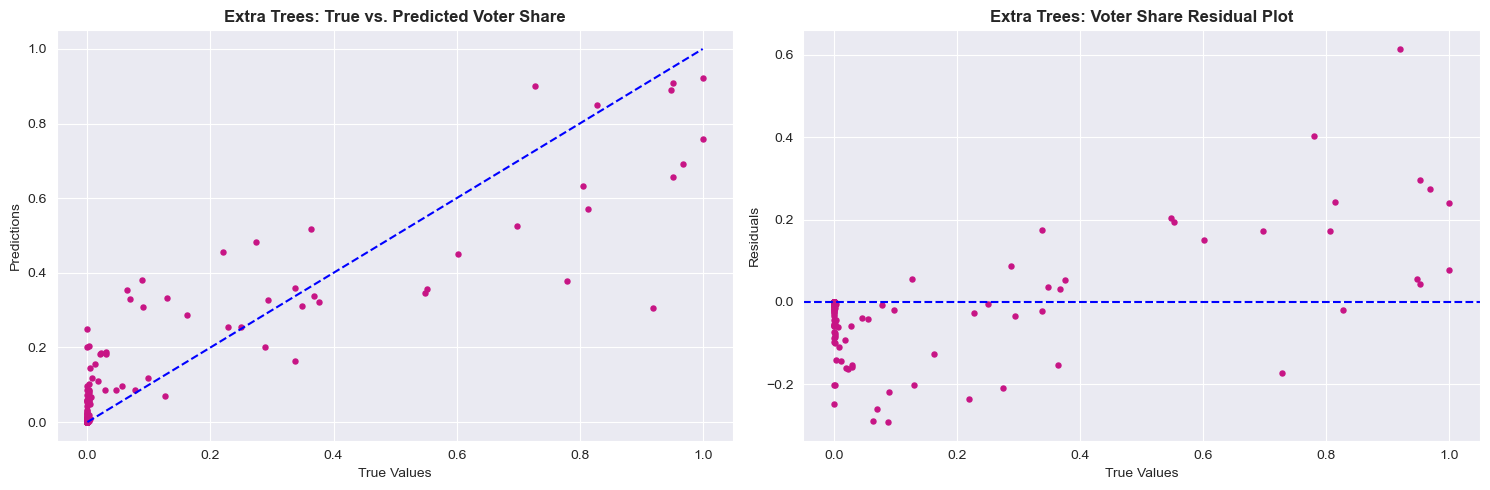

In [15]:
residplot('Extra Trees', preds_et)

In [16]:
best_estimator = gs_et.best_estimator_
extratrees = best_estimator.named_steps['et']
feature_importances = extratrees.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.01457218 0.01394458 0.01951472 0.09321787 0.07098476 0.09693564
 0.06164199 0.0821145  0.05243815 0.16577868 0.05230288 0.05699906
 0.04068367 0.01543855 0.04698225 0.03114897 0.0373398  0.03289562
 0.00709693 0.00796919]


In [17]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

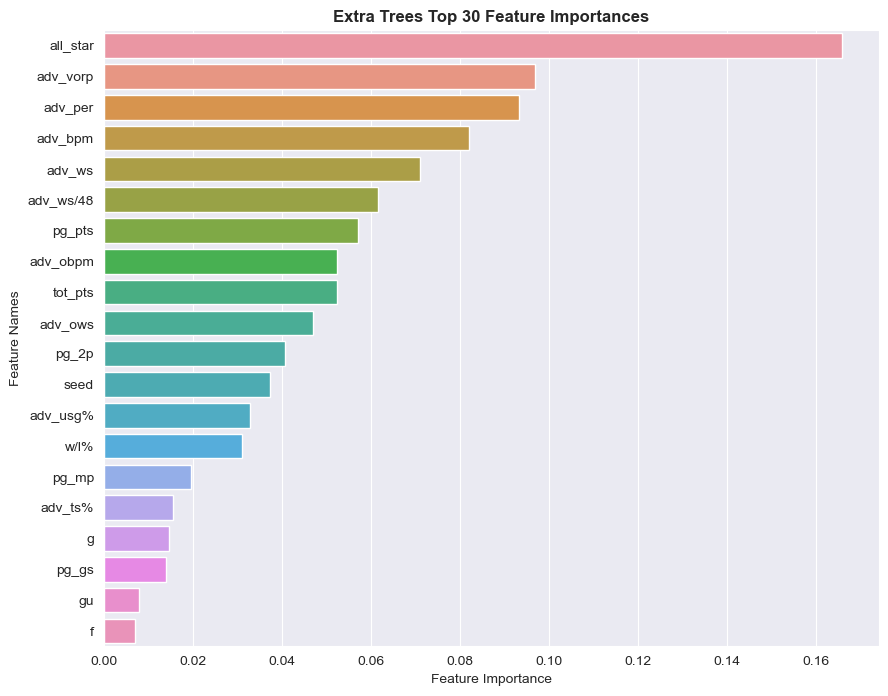

In [18]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Extra Trees Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/FI_ET_FINAL.png', dpi=192, bbox_inches='tight'); 

In [19]:
print(f'------ {b1}Extra Trees{b0} ------')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2021: {round(find_avgprec(preds_et, 2021),3)} ------')
print(f'------ 2022: {round(find_avgprec(preds_et, 2022),3)} ------')

------ Extra Trees ------
----- Avg Precision -----
------ 2021: 0.939 ------
------ 2022: 0.902 ------


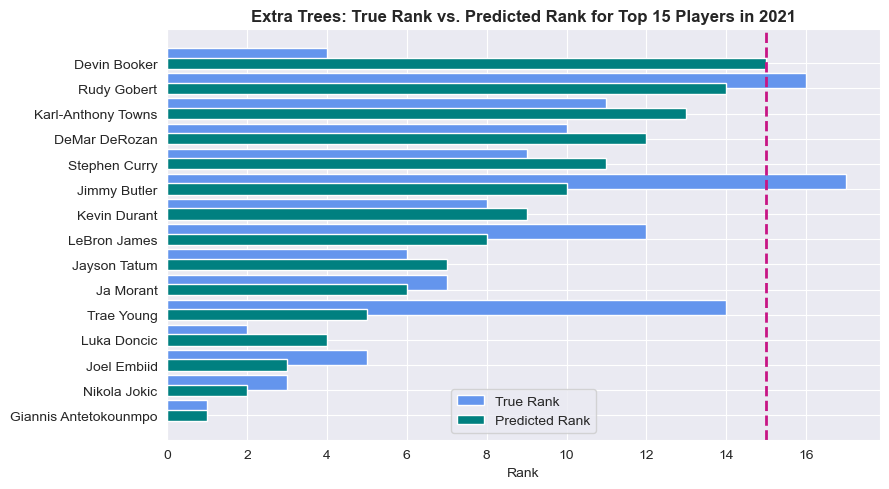

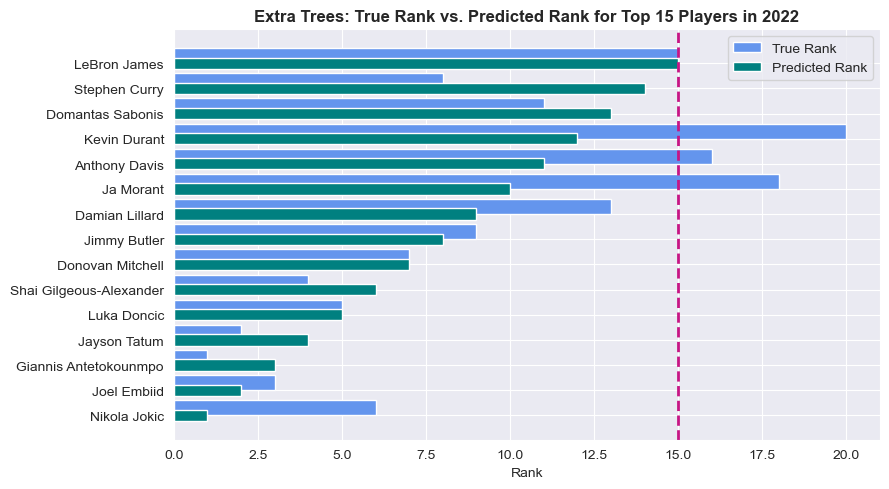

In [20]:
make_viz(preds_et, 2021, 'Extra Trees')
make_viz(preds_et, 2022, 'Extra Trees')

### Predicting All-NBA Team Placement

In [28]:
df['all_nba_winner_c'] = df['all_nba_winner'].map({1:1, 2:2, 3:3, 4:0, 0:0})

In [29]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

y_train_c = df['all_nba_winner_c'].loc[df.year.isin(train_yrs)]
y_test_c = df['all_nba_winner_c'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train_c.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test_c.shape}')

Train: X: (4093, 20), y: (4093,)
Test: X: (279, 20), y: (279,)


In [30]:
df.all_nba_winner_c.value_counts(normalize = True)

0    0.886551
2    0.037969
1    0.037740
3    0.037740
Name: all_nba_winner_c, dtype: float64

In [31]:
%%time
pipe_svc_c = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC(random_state=1527))
])

pgrid_svc_c =[{  
     'svc__C': [0.45222222222222225], 
     'svc__degree' : [2], 
     'svc__kernel': ['rbf'], 
    }]


gs_svc_c = GridSearchCV(pipe_svc_c, pgrid_svc_c, n_jobs=5)
gs_svc_c.fit(X_train, y_train_c)

# Make predictions for Accuracy Report
preds_svc_c = gs_svc_c.predict(X_test)

print(f'----------- {b1}Multiclass SVM w/ GridSearch{b0} -----------')
print(f'------------------ Train: {round(gs_svc_c.score(X_train, y_train_c),4)} -------------------')
print(f'------------------- Test: {round(gs_svc_c.score(X_test, y_test_c),4)} -------------------')
print('Best Params:', gs_svc_c.best_params_)

----------- Multiclass SVM w/ GridSearch -----------
------------------ Train: 0.9252 -------------------
------------------- Test: 0.9355 -------------------
Best Params: {'svc__C': 0.45222222222222225, 'svc__degree': 2, 'svc__kernel': 'rbf'}
CPU times: total: 0 ns
Wall time: 3.65 s


<Figure size 1600x400 with 0 Axes>

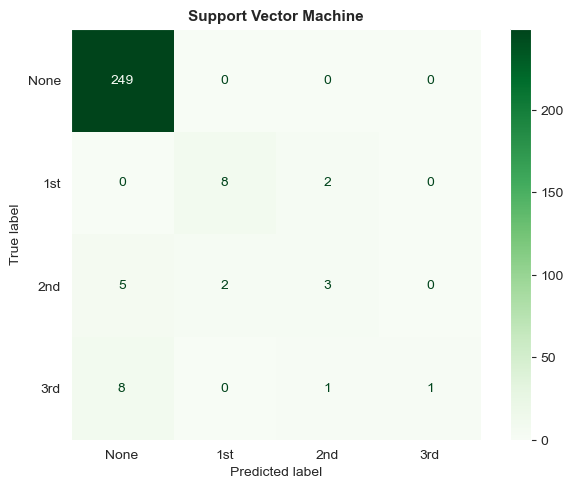

In [35]:
plt.figure(figsize=(16, 4))

ConfusionMatrixDisplay.from_predictions(y_test_c, preds_svc_c, display_labels=['None', '1st', '2nd', '3rd'], cmap = 'Greens');

plt.title('Support Vector Machine', fontweight='bold', fontsize=11);
plt.grid(False);
plt.tight_layout()
plt.show();

In [36]:
print(f'------------------- {b1}Multiclass SVC{b0} -------------------- \n  {classification_report(y_test_c, preds_svc_c, digits=4)}')

------------------- Multiclass SVC -------------------- 
                precision    recall  f1-score   support

           0     0.9504    1.0000    0.9746       249
           1     0.8000    0.8000    0.8000        10
           2     0.5000    0.3000    0.3750        10
           3     1.0000    0.1000    0.1818        10

    accuracy                         0.9355       279
   macro avg     0.8126    0.5500    0.5828       279
weighted avg     0.9306    0.9355    0.9184       279



### Predicting All-NBA Team Selection

In [37]:
df['binary_all_nba_winner'] = df['all_nba_winner'].map({0:0, 1:1, 2:1, 3:1, 4:0})

In [38]:
df.binary_all_nba_winner.value_counts(normalize = True)

0    0.886551
1    0.113449
Name: binary_all_nba_winner, dtype: float64

In [39]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

y_train_b = df['binary_all_nba_winner'].loc[df.year.isin(train_yrs)]
y_test_b = df['binary_all_nba_winner'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train_b.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test_b.shape}')

Train: X: (4093, 20), y: (4093,)
Test: X: (279, 20), y: (279,)


In [42]:
pipe_log_b = Pipeline([
                 ('sc', StandardScaler()),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000, random_state=1527))])

pgrid_logr_b = [{
    'logr__C': [0.05], 
    'logr__penalty': ['l1'], 
    'logr__max_iter': [750]
}]

gs_log_b = GridSearchCV(pipe_log_b, pgrid_logr_b, cv=5, n_jobs=10)
gs_log_b.fit(X_train, y_train_b)

preds_log_b = gs_log_b.predict(X_test)

print(f'------ {b1}Binary Logistic Regression w/ GridSearch{b0} -----') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print(f'------------------- Train: {round(gs_log_b.score(X_train, y_train_b),4)} -------------------')
print(f'------------------- Test: {round(gs_log_b.score(X_test, y_test_b),4)} --------------------')
print('Best Params:', gs_log_b.best_params_)

------ Binary Logistic Regression w/ GridSearch -----
------------------- Train: 0.9533 -------------------
------------------- Test: 0.9642 --------------------
Best Params: {'logr__C': 0.05, 'logr__max_iter': 750, 'logr__penalty': 'l1'}


<Figure size 1600x400 with 0 Axes>

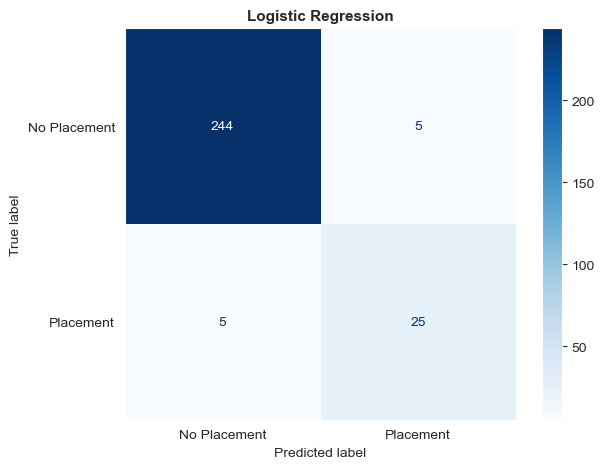

In [44]:
plt.figure(figsize=(16, 4))

ConfusionMatrixDisplay.from_predictions(y_test_b, preds_log_b, display_labels=['No Placement', 'Placement'], cmap = 'Blues');

plt.title('Logistic Regression', fontweight='bold', fontsize=11)
plt.grid(False)
plt.tight_layout()
plt.show();

In [45]:
print(f'\n------------------- {b1}Binary Logistic{b0} ------------------ \n {classification_report(y_test_b, preds_log_b, digits=4)} \n')


------------------- Binary Logistic ------------------ 
               precision    recall  f1-score   support

           0     0.9799    0.9799    0.9799       249
           1     0.8333    0.8333    0.8333        30

    accuracy                         0.9642       279
   macro avg     0.9066    0.9066    0.9066       279
weighted avg     0.9642    0.9642    0.9642       279
 



### Predicting NBA Player Salaries (in % of Cap Share)

In [47]:
df['pct_cap'] = df.salary_adj / df.salary_cap_adj 

In [48]:
# We have dummified Position into 3 Positions for All-NBA voting (G, F, C) - here it is more appropriate to dummify by the standard 5 positions (PG, SG, SF, PF, C)
df = pd.get_dummies(df, columns = ['pos_5'], prefix = 'pos5', drop_first=True)

In [49]:
feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'w/l%', 'seed', 'all_star', 'pos5_PG', 'pos5_SG', 'pos5_SF', 'pos5_PF', 'year', 'salary_cap_adj', 'career_length']

In [50]:
# Resetting X and y for the models to follow
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

y_train = df['pct_cap'].loc[df.year.isin(train_yrs)]
y_test = df['pct_cap'].loc[df.year.isin(hold_yrs)]

In [51]:
%%time

pipe_lgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('lgb', LGBMRegressor(random_state=1527))
])

pgrid_lgb = [{
     'lgb__learning_rate': np.linspace(0.01, 0.5, 15),
     'lgb__max_depth': [12],
     'lgb__n_estimators': [100],
     'lgb__num_leaves': [20],
    }]

gs_lgb = GridSearchCV(pipe_lgb, pgrid_lgb, cv=5, n_jobs=10)
gs_lgb.fit(X_train, y_train)

preds_lgb = gs_lgb.predict(X_test)

print(f'----------------- {b1}LGBM w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_lgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_lgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_lgb, squared=False),4)} --------------------')
print('Best Params:', gs_lgb.best_params_)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8868
[LightGBM] [Info] Number of data points in the train set: 4093, number of used features: 65
[LightGBM] [Info] Start training from score 0.145223
----------------- LGBM w/ GridSearch -----------------
------------------- Train: 0.8089 -------------------
------------------- Test: 0.7591 --------------------
------------------- RMSE: 0.0527 --------------------
Best Params: {'lgb__learning_rate': 0.07999999999999999, 'lgb__max_depth': 12, 'lgb__n_estimators': 100, 'lgb__num_leaves': 20}
CPU times: total: 1.08 s
Wall time: 16.5 s


In [52]:
%%time 

pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('xgb', XGBRegressor(random_state=1527))
])

pgrid_xgb = [{
     'xgb__n_estimators': [200],
     'xgb__max_depth': [3],
     'xgb__learning_rate': [0.06444444444444444],
     'xgb__reg_alpha': [0.44555555555555554],
    }]

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=10)
gs_xgb.fit(X_train, y_train)

preds_xgb = gs_xgb.predict(X_test)

print(f'----------------- {b1}XGB w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_xgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_xgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_xgb, squared=False),4)} --------------------')
print('Best Params:', gs_xgb.best_params_)

----------------- XGB w/ GridSearch -----------------
------------------- Train: 0.7027 -------------------
------------------- Test: 0.7436 --------------------
------------------- RMSE: 0.0544 --------------------
Best Params: {'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.44555555555555554}
CPU times: total: 3.08 s
Wall time: 2.55 s


##### <span style = 'color:mediumvioletred'> _We will stick with LGBM as our final model! It performed better than XGB, with a ~76% R^2, compared to ~74% with XGB._